In [3]:
%load_ext line_profiler

In [397]:
from ml_switching_reg_sim.data_creation import (
    MisclassificationCreator,
    UberDatasetCreator,
    UberDatasetCreatorHet,
)
from datetime import timedelta
import pandas as pd
import sys
import formulaic
import pyhdfe

sys.path.append("/Users/lordflaron/Documents/uganda-uber-paper/paper/scripts")
from regression import RegressionData
from ml_switching_reg.cm import cm_4, cm_10
from numba import jit

import autograd.numpy as np
import autograd as ag
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw, cdist_dtw
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [503]:
# For simulations

u = UberDatasetCreatorHet(drivers=1000, time_periods=30, regimes=3)

drought_cov = np.array([[6, 3, -1], 
                        [3, 3.5, 0], 
                        [-1, 0, 1]])

df, mw, [beta0, beta1], y_sd = u.construct(
    seed=1,
    output_true_beta=True,
    output_sigma=True,
    y_sd=[1, 1, 1],
    beta1=[-0.6, 0.2, 0.7],
    beta0=[1, 2, 3],
    weight=0.5,
    drought_cov=drought_cov
)

beta_regime_0 = np.array([beta0[0], beta1[0]])[:, np.newaxis]
beta_regime_1 = np.array([beta0[1], beta1[1]])[:, np.newaxis]
beta_regime_2 = np.array([beta0[2], beta1[2]])[:, np.newaxis]

In [486]:
# For simulations
R = df["regime"].values[:, np.newaxis]
y = df["y"].values[:, np.newaxis]

W0 = np.concatenate(
    [np.ones((u.drivers * u.time_periods, 1)), df["drought_0"].values.reshape(-1, 1)],
    axis=1,
)  # add intercept
W1 = np.concatenate(
    [np.ones((u.drivers * u.time_periods, 1)), df["drought_1"].values.reshape(-1, 1)],
    axis=1,
)
W2 = np.concatenate(
    [np.ones((u.drivers * u.time_periods, 1)), df["drought_2"].values.reshape(-1, 1)],
    axis=1,
)

W = [W0, W1, W2]

In [504]:
df.filter(like='drought').corr()

,drought_0,drought_1,drought_2
drought_0,1.000000,0.425156,-0.409495
drought_1,0.425156,1.000000,0.145879
drought_2,-0.409495,0.145879,1.000000


In [506]:
beta0 = np.array([1]*6).flatten()

In [507]:
mod = MLSwitchingRegIRLS(y=y, W=W, R=R, pi=mw)

mod.fit(beta0[:, np.newaxis], [1])

Starting iteration 0 with theta: [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Norm: 3.582129431759847
Starting iteration 1 with theta: [[1.61232131]
 [0.05091977]
 [2.11013698]
 [0.44239361]
 [2.80506889]
 [0.87578747]
 [3.59594475]]
Norm: 2.885970723680898
Starting iteration 2 with theta: [[ 1.37915595]
 [-0.12209317]
 [ 2.41067741]
 [ 0.61540045]
 [ 3.42898184]
 [ 1.16944845]
 [ 0.83030424]]
Norm: 0.6124230474700721
Starting iteration 3 with theta: [[ 1.13994628]
 [-0.4121241 ]
 [ 2.2337178 ]
 [ 0.3913836 ]
 [ 3.21286109]
 [ 0.89183749]
 [ 0.99897109]]
Norm: 0.26242486799915066
Starting iteration 4 with theta: [[ 0.97403765]
 [-0.55622309]
 [ 2.14347582]
 [ 0.31536265]
 [ 3.18960322]
 [ 0.8357449 ]
 [ 0.94450538]]
Norm: 0.11995837960591688
Starting iteration 5 with theta: [[ 0.91743809]
 [-0.61048591]
 [ 2.08222148]
 [ 0.26694575]
 [ 3.16112857]
 [ 0.79925705]
 [ 0.94261057]]
Norm: 0.054222260977928996
Starting iteration 6 with theta: [[ 0.89507806]
 [-0.63302722]
 [ 2.04979894]
 [ 0.24349716

array([[ 0.88336704],
       [-0.64961793],
       [ 2.0140297 ],
       [ 0.22253082],
       [ 3.14657431],
       [ 0.77164631],
       [ 0.94194905]])

## IRLS

In [222]:
drop_date = "'2017-01'< date <='2019-12' and not '2018-01'<=date<='2018-07'"

lag_columns = [
    "intensity",
    "neg_intensity",
    "ind_low_intensity",
    "ind_intensity",
    "ind_pos_low_intensity",
    "ind_pos_intensity",
]

reg_data = RegressionData(
    outlier_quantile=0.99,
    drought_low=-1,
    drought_high=-1.5,
    lags=[
        0,1,
    ],
    lag_columns=lag_columns,
    drop_date=drop_date,
    driver_path="/Users/lordflaron/Documents/uganda-uber-paper/paper/data/uber_data/uganda_data/processed/drivers_all_hours.csv",
    weather_path="/Users/lordflaron/Documents/uganda-uber-paper/paper/data/weather/data/asap_data/raw/country_209_var_20_set_1_class_1_sensor_3.csv",
)

In [137]:
def Pr(r, r_hat, pi, sigma2, y, W, beta):
    regimes = np.array([
        np.exp(-((y - W[i] @ beta[i]) ** 2) / (2 * sigma2)) for i in range(len(W))
    ]).squeeze()

    F = np.array([pi[:, i][np.newaxis, :] @ regimes for i in range(len(W))]).squeeze()

    cond_prob = pi[r_hat, r] * regimes[r_hat] / F[r]

    return cond_prob[:, np.newaxis]


RR = lambda r, r_hat, sigma2, beta, y, W, R, pi: np.where(R == r_hat, 1, 0) * Pr(
    r, r_hat, pi, sigma2, y, W, beta
)


def irls(y, W, R, pi, beta_0, sigma2_0, gaul_names=None):
    num_params = W[0].shape[1]  # change if different number of parameters per regime
    n_regimes = len(np.unique(R))
    tol = 1e-6
    max_iter = 1000
    theta_old = np.vstack([beta_0, sigma2_0])

    for i in range(max_iter):
        theta = np.vsplit(
            theta_old, [i * num_params for i in range(1, n_regimes)] + [-1]
        )  # last one is sigma2
        print(f"Starting iteration {i} with theta: {theta_old}")

        # generate RR for all regimes
        RR_hat = np.zeros((len(W), len(W[0])))
        for r in range(len(W)):
            for r_hat in range(len(W)):
                RR_hat[r, :] += RR(
                    r, r_hat, theta[-1], theta[:-1], y, W, R, pi
                ).squeeze()
            
        def beta_h(r, W, RR_hat, y):
            return np.linalg.inv(
                np.linalg.multi_dot([W.T, np.diag(RR_hat[r].flatten()), W])
            ).dot(np.linalg.multi_dot([W.T, np.diag(RR_hat[r].flatten()), y]))
            
            
        beta_hat = [beta_h(i, W[i], RR_hat, y) for i in range(n_regimes)]

        # find optimal sigma2
        sigma2_hat = 0
        for r in range(n_regimes):
            sigma2_hat += np.sum(
                RR_hat[r][:, np.newaxis] * (y - W[r] @ beta_hat[r]) ** 2
            )

        sigma2_hat /= W[0].shape[0]

        theta = np.vstack([
            np.array(beta_hat).flatten().reshape(num_params * n_regimes, 1),
            sigma2_hat,
        ])
            
        
        print(f"Norm: {np.linalg.norm(theta - theta_old)}")
        if np.linalg.norm(theta - theta_old) < tol:
            theta_print = [f"{t:.3f}" for t in theta.flatten()]
            print(
                f"Found in {i} iterations; with theta: {theta_print}, and norm: {np.linalg.norm(theta - theta_old)}"
            )
            break
        theta_old = theta.copy()
    return theta

In [138]:
class MLSwitchingRegIRLS:
    
    def __init__(self, y, W, pi, R):
        self.y = y
        self.W = W
        self.pi = pi # rows are true labels and columns are predicted labels; same as sklearn
        self.R = R
        
        self.num_params = self.W[0].shape[1]  # change if different number of parameters per regime
        self.n_regimes = len(np.unique(self.R))
        
    # def yWb(self, beta):
        
    def Pr(self, sigma2, beta):
        
        W_mat = np.array(self.W)
        beta = beta.reshape(self.n_regimes, self.num_params, 1)
                
        regimes = np.exp(-((self.y.T - np.einsum("ijk,ikl -> ij", W_mat, beta)) ** 2)/2*sigma2)

        pi_r = np.einsum("ij,ik -> ijk", self.pi, regimes)
                
        F = self.pi.T @ regimes

        # cond_prob = self.pi[r, r_hat] * regimes[r] / F[r_hat] 
        # self.pi is with rows as true labels and columns as predicted labels
        # For ex: If the true regime is 0 and you're predicted to be regime 1, then you'll have
        # pi_01 * regime 0 as your true impact divided by the total probability of being chosen into regime 1

        cond_prob = pi_r / F
        
        return cond_prob
    
    def RR_hat(self, beta, sigma2):
        dummy_matrix = np.eye(self.n_regimes)[self.R].squeeze()
        RR = dummy_matrix.T * self.Pr(sigma2, beta)
        RR_hat = np.sum(RR, axis=1)
        return RR_hat
    
    def beta_h(self, r, rrh):
        return np.linalg.inv(
            np.linalg.multi_dot([self.W[r].T, np.diag(rrh[r].flatten()), self.W[r]])
        ).dot(np.linalg.multi_dot([self.W[r].T, np.diag(rrh[r].flatten()), self.y]))
        
    def sigma2_h(self, rrh, beta):
        W_mat = np.array(self.W)
        beta = beta.reshape(self.n_regimes, self.num_params, 1)
            
        sigma2_hat = np.sum(rrh * ((self.y.T - np.einsum("ijk,ikl -> ij", W_mat, beta)) ** 2))
        
        sigma2_hat = sigma2_hat / W_mat.shape[1]

        return sigma2_hat
    
    def jacobian(self, theta_old):
        rrh = self.RR_hat(theta_old[:-1], theta_old[-1])
                
        beta_hat = [self.beta_h(i, rrh) for i in range(self.n_regimes)]
        
        sigma2_hat = self.sigma2_h(rrh, theta_old[:-1])

        theta = np.vstack([
            np.array(beta_hat).flatten().reshape(self.num_params * self.n_regimes, 1),
            sigma2_hat,
        ])
        
        return theta - theta_old, theta
        
    def _irls(self, beta_0, sigma2_0,  
              max_iter=1000, tol=1e-6):
        
        theta_old = np.vstack([beta_0, sigma2_0])

        for i in range(max_iter):
            print(f"Starting iteration {i} with theta: {theta_old}")

            # calculate jacobian and get new theta
            jac, theta = self.jacobian(theta_old)
            
            norm = np.linalg.norm(jac)
                        
            print(f"Norm: {norm}")
            if norm < tol:
                theta_print = [f"{t:.3f}" for t in theta.flatten()]
                print(
                    f"Found in {i} iterations; with theta: {theta_print}, and norm: {norm}"
                )
                break
            theta_old = theta.copy()
        return theta
    
    def fit(self, beta_0, sigma2_0, max_iter=1000, tol=1e-6):
        return self._irls(beta_0, sigma2_0, max_iter, tol)

In [371]:
gaul_region_map_long_name = {
    "south highlands": "West",
    "west highlands": "West",
    "lake albert": "West",
    "eastern": "East",
    "west nile": "North",
    "mid northen": "North",
    "karamoja": "North",
    "lake victoria": "Central",
    "south drylands": "West",
    "south eastern": "East",
}

gauls = [
        "eastern",
        "karamoja",
        "lake albert",
        "lake victoria",
        "mid northen",
        "south eastern",
        "south drylands",
        "south highlands",
        "west nile",
        "west highlands",
    ]


df_WMON = reg_data.regression_df(freq="W-MON")
df = reg_data.regression_df(freq="M")
df_2M = reg_data.regression_df(freq="2M")
df_3M = reg_data.regression_df(freq="BQ-JAN")

df_all_gaul = (
    reg_data.regression_df(freq="M", weather="all_weather")
    .reset_index()
    .drop_duplicates(["gaul", "date"])
    .groupby(["gaul", "date"])["lagged_1_neg_intensity"]
    .mean()
    .unstack(0)
)

df_all_gaul_2M = (
    reg_data.regression_df(freq="2M", weather="all_weather")
    .reset_index()
    .drop_duplicates(["gaul", "date"])
    .groupby(["gaul", "date"])["lagged_1_neg_intensity"]
    .mean()
    .unstack(0)
)

df_all_gaul_3M = (
    reg_data.regression_df(freq="BQ-JAN", weather="all_weather")
    .reset_index()
    .drop_duplicates(["gaul", "date"])
    .groupby(["gaul", "date"])["lagged_1_neg_intensity"]
    .mean()
    .unstack(0)
)

df_all_gaul_WMON = (
    reg_data.regression_df(freq="W-MON", weather="all_weather")
    .reset_index()
    .drop_duplicates(["gaul", "date"])
    .groupby(["gaul", "date"])["lagged_1_neg_intensity"]
    .mean()
    .unstack(0)
)



df_all_region_3M = (
    reg_data.regression_df(freq="BQ-JAN", weather="all_weather")
    .reset_index()
    .drop_duplicates(["gaul", "date"])
    .assign(region = lambda df: df['gaul'].map(gaul_region_map_long_name))
    .groupby(["region", "date"])["lagged_1_neg_intensity"]
    .mean()
    .unstack(0)
)

df_gaul = df.reset_index().merge(df_all_gaul, on="date")

df_gaul_2M = df_2M.reset_index().merge(df_all_gaul_2M, on="date")

df_gaul_WMON = df_WMON.reset_index().merge(df_all_gaul_WMON, on="date")

df_gaul_3M = df_3M.reset_index().merge(df_all_gaul_3M, on="date")

df_region_3M = df_3M.reset_index().merge(df_all_region_3M, on="date").assign(region = lambda df: df['gaul_class'].map(gaul_region_map_long_name))

In [311]:
df_gaul_3M[gauls + ['date']].drop(columns='date')

,eastern,karamoja,lake albert,lake victoria,mid northen,south eastern,south drylands,south highlands,west nile,west highlands
0,1.832,1.190,1.848,1.673,2.068,1.381,0.528,-0.119,0.668,0.423
1,1.832,1.190,1.848,1.673,2.068,1.381,0.528,-0.119,0.668,0.423
2,1.832,1.190,1.848,1.673,2.068,1.381,0.528,-0.119,0.668,0.423
3,1.832,1.190,1.848,1.673,2.068,1.381,0.528,-0.119,0.668,0.423
4,1.832,1.190,1.848,1.673,2.068,1.381,0.528,-0.119,0.668,0.423
...,...,...,...,...,...,...,...,...,...,...
32842,0.586,1.023,0.930,0.350,1.004,0.466,-0.177,1.038,1.303,0.598
32843,0.586,1.023,0.930,0.350,1.004,0.466,-0.177,1.038,1.303,0.598
32844,0.586,1.023,0.930,0.350,1.004,0.466,-0.177,1.038,1.303,0.598
32845,0.586,1.023,0.930,0.350,1.004,0.466,-0.177,1.038,1.303,0.598


For n_clusters = 2 The average silhouette_score is : 0.2062700281570083
For n_clusters = 3 The average silhouette_score is : 0.36288632287679257
For n_clusters = 4 The average silhouette_score is : 0.2733962913672322
For n_clusters = 5 The average silhouette_score is : 0.25231829681242013
For n_clusters = 6 The average silhouette_score is : -0.00024466856457121267


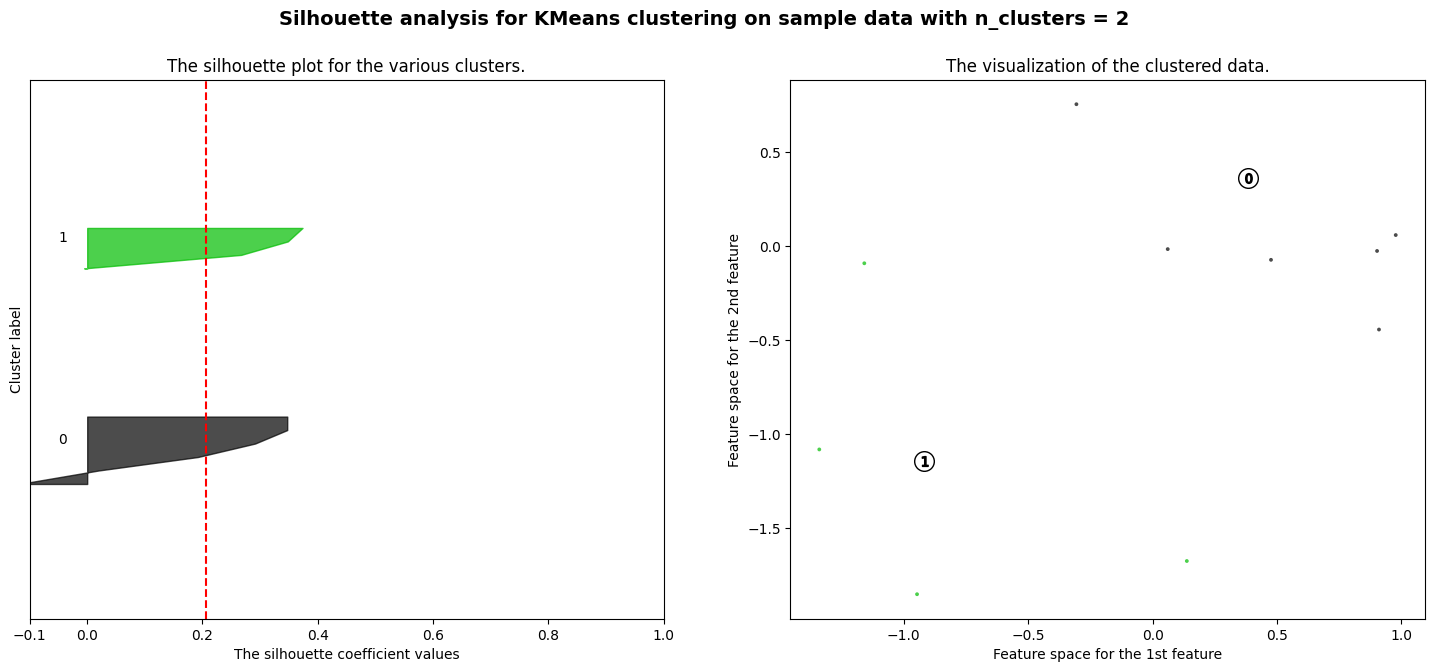

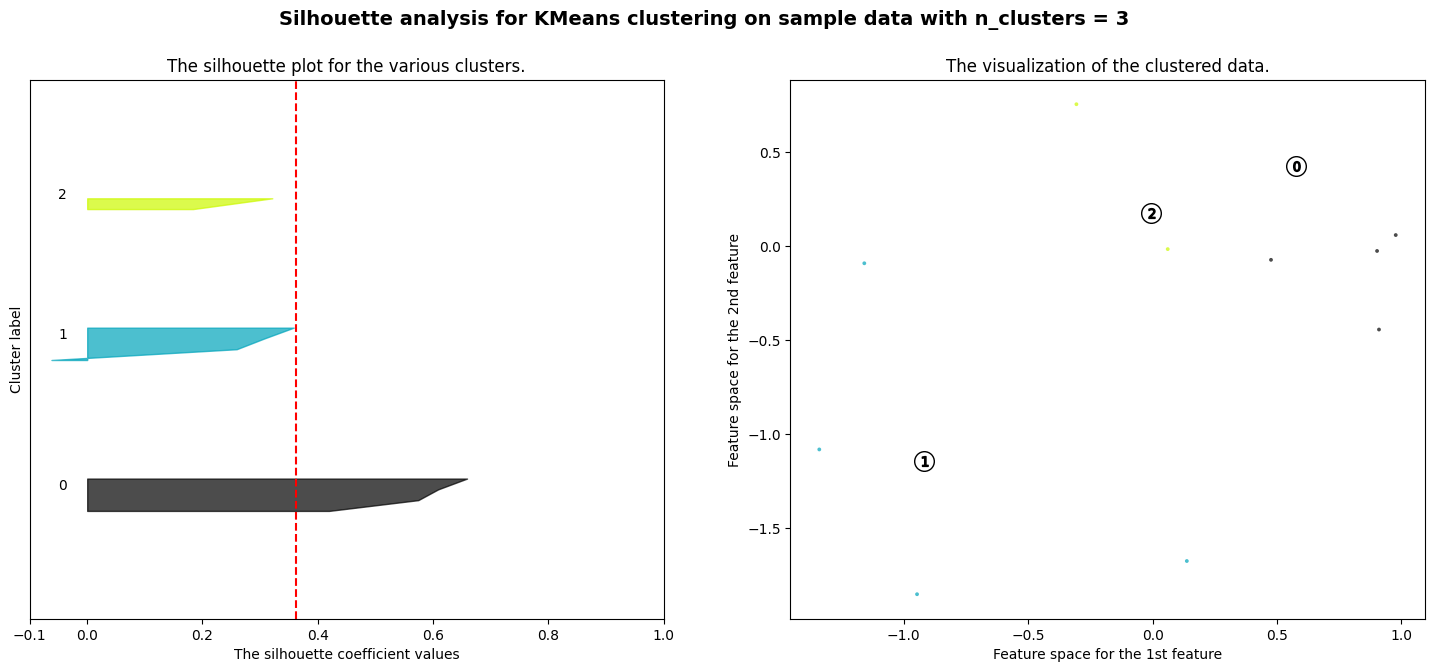

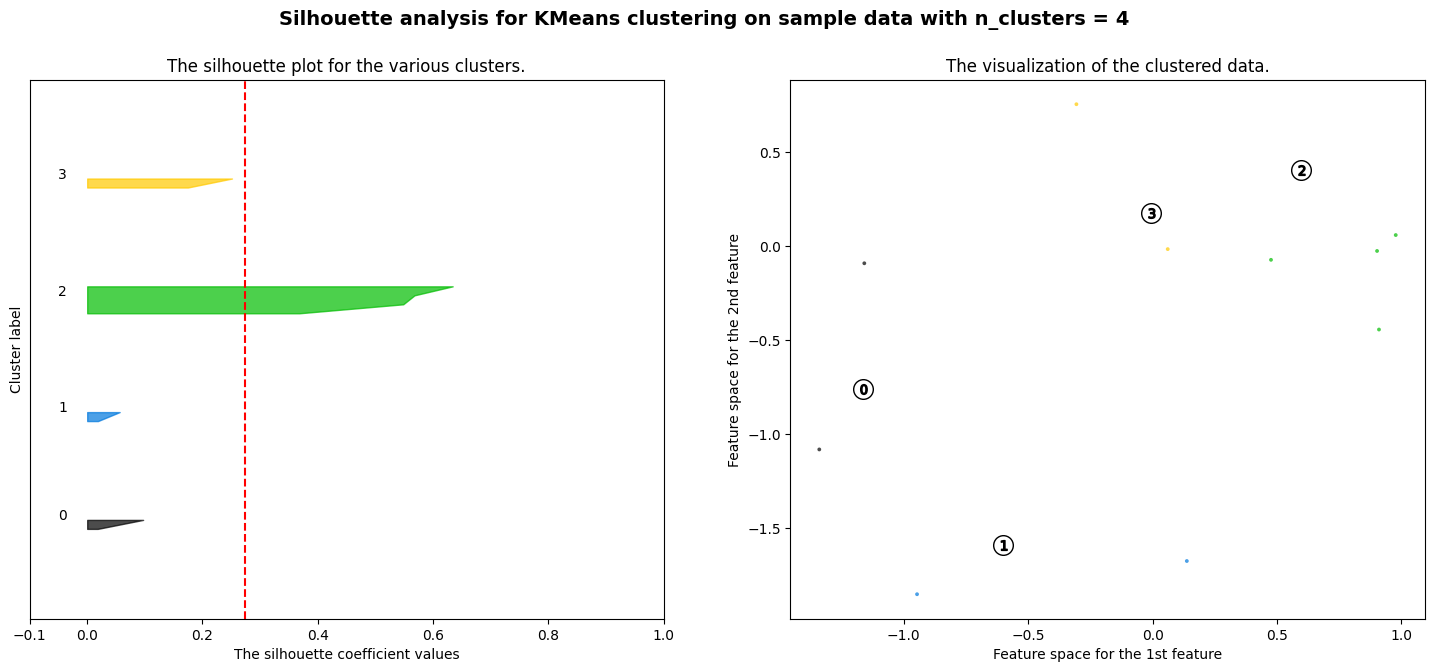

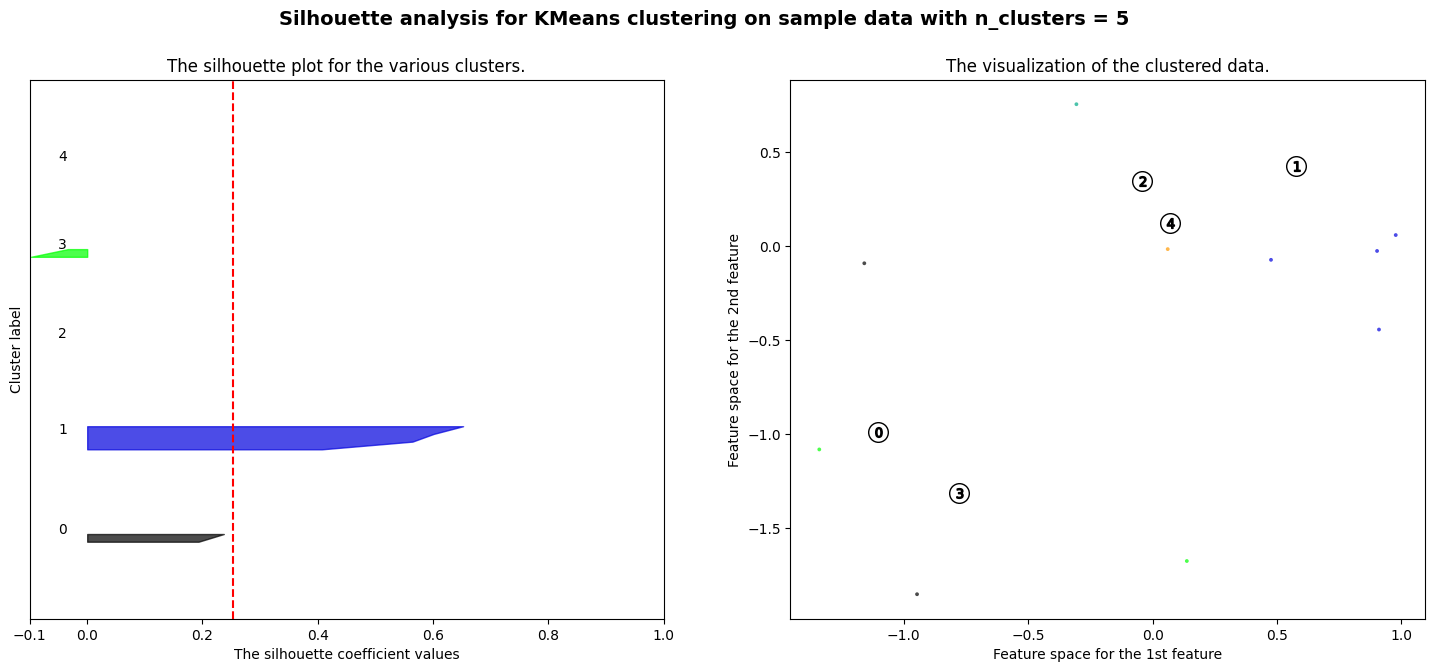

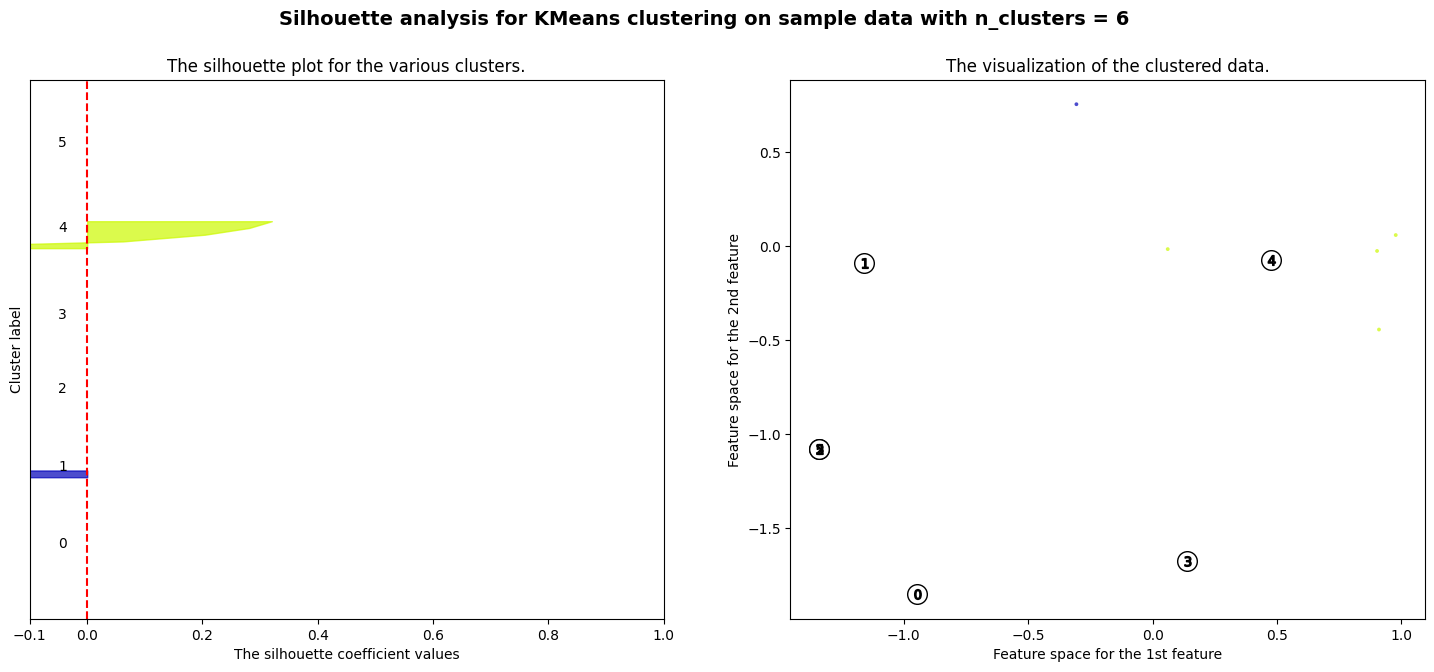

In [408]:
k = TimeSeriesKMeans(n_clusters=4, metric='dtw')

weather = df_gaul_3M[gauls + ['date']].drop_duplicates('date').drop(columns='date').values

X = TimeSeriesScalerMeanVariance().fit_transform(weather)
# pred = k.fit_predict(X_train)

# mapper = {k : f"cluster_{v}" for k,v in zip(gauls, pred)}

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = TimeSeriesKMeans(n_clusters=n_clusters, metric='softdtw')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    
    dtw_dist = cdist_dtw(X)
    sample_silhouette_values = silhouette_samples(dtw_dist, cluster_labels, metric='precomputed')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [470]:
k = TimeSeriesKMeans(n_clusters=2, metric='softdtw')

weather = df_gaul_3M[gauls + ['date']].drop_duplicates('date').drop(columns='date').values

X_train = TimeSeriesScalerMeanVariance().fit_transform(weather)
pred = k.fit_predict(X_train)

mapper = {k : f"cluster_{v}" for k,v in zip(gauls, pred)}

In [519]:
formula = lambda w: formulaic.Formula(
    f"np.arcsinh(hours_online) ~ -1 + `{w}`"
)

def irls_data(formula, df, pi):
    
    gauls = [
        "eastern",
        "karamoja",
        "lake albert",
        "lake victoria",
        "mid northen",
        "south eastern",
        "south drylands",
        "south highlands",
        "west nile",
        "west highlands",
    ]
    
    regions = [
        'North',
        'East',
        'West',
        'Central'
    ]

    # cluster_cols = (
    #     df
    #     .set_index(['hashed_driver_uuid', 'date'])[gauls]
    #     .stack()
    #     .reset_index()
    #     .rename({'level_2' : 'weather_col', 0:'value'}, axis=1)
    #     .assign(new_R = lambda df: df['weather_col'].map(mapper))
    #     .groupby(['hashed_driver_uuid', 'date', 'new_R'])
    #     .min()
    #     .drop(columns='weather_col')
    #     .unstack()
    #     .droplevel(axis=1, level=0)
    #     .reset_index()
    #     )
    
    # df = df.merge(cluster_cols, on=['hashed_driver_uuid', 'date']).assign(new_R = lambda df: df['gaul_class'].map(mapper))
    
    fe = pyhdfe.create(
        df[["hashed_driver_uuid", 'month', 'year']].values,
        drop_singletons=True,
    )

    singletons = fe.singleton_indices

    y = formula("eastern").get_model_matrix(df).lhs.values
    y_demeaned = fe.residualize(y)

    W = []
    W_demeaned = []

    for r in gauls:
        W.append(formula(r).get_model_matrix(df).rhs.values)
        W_demeaned.append(fe.residualize(formula(r).get_model_matrix(df).rhs))
        
    ## use clustering
    

    R = pd.Categorical(
        df.gaul_class,
        categories=gauls,
    ).codes[:, np.newaxis]  # also drop the singletons
    
    # R = pd.Categorical(
    #     df.new_R,
    #     categories=df.new_R.unique(),
    # ).codes[:, np.newaxis]
    
    # R = pd.Categorical(
    #     df.region,
    #     categories=df.region.unique(),
    # ).codes[:, np.newaxis]
        
    R_demeaned = R[~singletons]

    x0 = np.full((W[0].shape[1] * len(W),1), .1)
    
    # old_faithful = irls(y_demeaned, W_demeaned, R, cm_10.T, x0, 1)
    
    mod = MLSwitchingRegIRLS(y = y_demeaned, 
                             W = W_demeaned, 
                             pi=pi,
                             R = R_demeaned)
    
    mod.fit(x0, 1)


In [186]:
# keep for monthly results
params_M = irls_data(formula, df_gaul)

Starting iteration 0 with theta: [[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [1. ]]


KeyboardInterrupt: 

In [217]:
## 2 month results
params_2M = irls_data(formula, df_gaul_2M)

Starting iteration 0 with theta: [[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [1. ]]


KeyboardInterrupt: 

In [13]:
# weekly results

params_WMON = irls_data(formula, df_gaul_WMON)

Starting iteration 0 with theta: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


: 

In [449]:
cm_df = pd.DataFrame(index=gauls, columns=gauls, data=cm_10)#.rename({'eastern' : 'eastern_1'}).sum(axis=0)

In [450]:
cm_df

,eastern,karamoja,lake albert,lake victoria,mid northen,south eastern,south drylands,south highlands,west nile,west highlands
eastern,0.751734,0.033604,0.010664,0.013363,0.097453,0.074562,0.005610,0.002340,0.021899,0.005466
karamoja,0.011924,0.886443,0.001720,0.000594,0.016015,0.001700,0.000312,0.000000,0.002532,0.000278
lake albert,0.011535,0.004056,0.524252,0.028755,0.021722,0.013008,0.043709,0.075303,0.081772,0.117751
lake victoria,0.087357,0.016222,0.124183,0.707746,0.034500,0.186958,0.197507,0.121676,0.067089,0.113118
mid northen,0.029875,0.033604,0.005848,0.001683,0.781412,0.003656,0.001636,0.001276,0.028354,0.002038
south eastern,0.083857,0.015064,0.022016,0.049196,0.019593,0.675990,0.011998,0.003404,0.017595,0.012970
south drylands,0.005055,0.004056,0.050224,0.168226,0.001448,0.022785,0.415894,0.166986,0.003797,0.137669
south highlands,0.001685,0.000000,0.016168,0.007721,0.000170,0.003486,0.118426,0.469049,0.001646,0.069576
west nile,0.010952,0.005794,0.022360,0.003464,0.025300,0.003741,0.001169,0.000213,0.768481,0.004540
west highlands,0.006027,0.001159,0.222566,0.019253,0.002385,0.014113,0.203740,0.159753,0.006835,0.536594


In [472]:
cm_cluster = (
    cm_df
    .rename(index=mapper)
    .groupby(level=0)
    .sum()
    .T
    .rename(index=mapper)
    .groupby(level=0)
    .sum()
    .apply(lambda x: x/x.sum(), axis=1)
    .T
    .values
    )

In [473]:
mapper

{'eastern': 'cluster_0',
 'karamoja': 'cluster_0',
 'lake albert': 'cluster_1',
 'lake victoria': 'cluster_1',
 'mid northen': 'cluster_1',
 'south eastern': 'cluster_1',
 'south drylands': 'cluster_1',
 'south highlands': 'cluster_0',
 'west nile': 'cluster_0',
 'west highlands': 'cluster_1'}

In [515]:
df_gaul_3M.assign(log_hours = lambda df: np.log(df['hours_online']))

/opt/anaconda3/envs/uganda-uber-paper/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,hashed_driver_uuid,date,weekly_earnings_local,hours_online,hours_online_4,hours_online_10,hours_online_16,hours_online_22,earnings_index_4,earnings_index_10,...,karamoja,lake albert,lake victoria,mid northen,south drylands,south eastern,south highlands,west highlands,west nile,log_hours
0,0008007eceb3973e75e6d59518d68211,2019-04-30,4.625209e+05,44.395321,7.872986,11.523035,12.419699,12.579600,1.758024,1.687716,...,1.190,1.848,1.673,2.068,0.528,1.381,-0.119,0.423,0.668,3.793134
1,000b4c249224f4c13214c5ea457a6a95,2019-04-30,3.344489e+05,36.455015,10.085771,11.149408,15.204931,0.014905,1.916723,1.796967,...,1.190,1.848,1.673,2.068,0.528,1.381,-0.119,0.423,0.668,3.596079
2,0036f4e9bcd2609656706bb93d72863f,2019-04-30,6.723545e+06,755.238306,96.763546,241.998243,248.412434,168.064083,1.905680,1.858447,...,1.190,1.848,1.673,2.068,0.528,1.381,-0.119,0.423,0.668,6.627033
3,0045f2b01ea5d2ed497d894fe5567303,2019-04-30,1.170217e+06,111.599564,7.409996,12.062526,60.687473,31.439570,1.943957,1.885383,...,1.190,1.848,1.673,2.068,0.528,1.381,-0.119,0.423,0.668,4.714917
4,00467911fd7dfad454ea6a6b380c5579,2019-04-30,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.190,1.848,1.673,2.068,0.528,1.381,-0.119,0.423,0.668,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32842,ff5ab1330bbe831d64b0d5253af2d54a,2017-04-28,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.023,0.930,0.350,1.004,-0.177,0.466,1.038,0.598,1.303,-inf
32843,ff80a697e7d36b1185e8e298f0bc15e8,2017-04-28,2.025325e+06,211.716667,3.400000,128.316667,80.000000,0.000000,1.820940,1.881416,...,1.023,0.930,0.350,1.004,-0.177,0.466,1.038,0.598,1.303,5.355249
32844,ffe47273ab18af83afa1c7fe86b3503f,2017-04-28,1.363775e+06,163.366667,13.866667,48.450000,70.733333,30.316667,1.924431,1.933591,...,1.023,0.930,0.350,1.004,-0.177,0.466,1.038,0.598,1.303,5.095997
32845,fff148bb9c7f8e8f66e8f22f47623f98,2017-04-28,1.038875e+06,71.250000,11.216667,7.466667,14.433333,38.133333,1.904231,1.885808,...,1.023,0.930,0.350,1.004,-0.177,0.466,1.038,0.598,1.303,4.266195


In [524]:
# 3 month results

formula_log = lambda w: formulaic.Formula(
    f"np.log(hours_online) ~ -1 + `{w}`"
)

d = df_gaul_3M.assign(log_hours = lambda df: np.log(df['hours_online']).replace([np.inf, -np.inf], np.nan)).dropna(subset='log_hours')

params_3M = irls_data(formula_log, d, pi=cm_10)

/opt/anaconda3/envs/uganda-uber-paper/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Starting iteration 0 with theta: [[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [1. ]]
Norm: 0.2823139886920925
Starting iteration 1 with theta: [[ 2.87130754e-02]
 [-7.16787483e-02]
 [ 8.41786301e-02]
 [ 4.28472649e-02]
 [ 6.01773263e-02]
 [ 9.77264839e-03]
 [ 6.23808293e-02]
 [-9.50593840e-03]
 [ 1.47560019e-01]
 [ 6.95558444e-04]
 [ 1.07982555e+00]]
Norm: 0.1163635467033207
Starting iteration 2 with theta: [[ 0.01807807]
 [-0.13780336]
 [ 0.10586238]
 [ 0.03733436]
 [ 0.06545422]
 [-0.01572223]
 [ 0.06914925]
 [-0.0704123 ]
 [ 0.19952543]
 [-0.03697586]
 [ 1.07857696]]
Norm: 0.07168453625113207
Starting iteration 3 with theta: [[ 0.01669677]
 [-0.17971839]
 [ 0.13064899]
 [ 0.03777327]
 [ 0.06991771]
 [-0.02827279]
 [ 0.07998622]
 [-0.1123212 ]
 [ 0.21602361]
 [-0.05799406]
 [ 1.07820693]]
Norm: 0.0532303628785098
Starting iteration 4 with theta: [[ 0.01736509]
 [-0.21024817]
 [ 0.15559133]
 [ 0.03836242]
 [ 0.07204758]
 [-0.03610293]
 [ 0.08967965]
 [-0.1429

In [ ]:
gauls = [
        "eastern",
        "karamoja",
        "lake albert",
        "lake victoria",
        "mid northen",
        "south eastern",
        "south drylands",
        "south highlands",
        "west nile",
        "west highlands",
    ]